# Projet CNN (Chats vs Chiens)

**Objectifs**  
- Charger un dataset d’images (Kaggle Cats vs Dogs) avec `torchvision.datasets.ImageFolder`  
- Définir des **transforms** (redimensionnement, recadrage, augmentation)  
- Construire des **DataLoaders** entraînement/test  
- **Projet** : comparer un **CNN from scratch** vs **Transfert Learning (ResNet18)**  
- Suivre **loss/accuracy/précision/recall/F1**, tracer les courbes, **sauvegarder** et **recharger** le meilleur modèle




## Prérequis & Imports

- Activez un **GPU** dans Colab : `Exécution > Modifier le type d’exécution > Accélérateur matériel > GPU`  
- Les cellules suivantes importent PyTorch / Torchvision et utilitaires.  
- (Optionnel) Installez des librairies supplémentaires si besoin.


In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# (Optionnel) outils utiles
# !pip -q install torchmetrics==1.4.0

import os, random, time
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

print('PyTorch version:', torch.__version__)
print('CUDA dispo ? ', torch.cuda.is_available())

PyTorch version: 2.8.0+cu126
CUDA dispo ?  True


---
## 1 — Charger les images (ImageFolder) & DataLoader

Ici, on :  
1. **Redimensionne** puis **centre-cadre** en 224×224,  
2. Convertit en **tenseur** (`ToTensor()`),  
3. Crée un **DataLoader** (batch=32, mélangé).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from torchvision import datasets, transforms
import torch

data_dir = '/content/drive/MyDrive/DIT/Deep learning/devoir/Cat_Dog_data/train'

transform = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(data_dir, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

len(dataset), len(dataloader)

(22500, 704)

### Visualiser un batch

Définissons un utilitaire `imshow` pour afficher une image (sans normalisation pour visualisation).

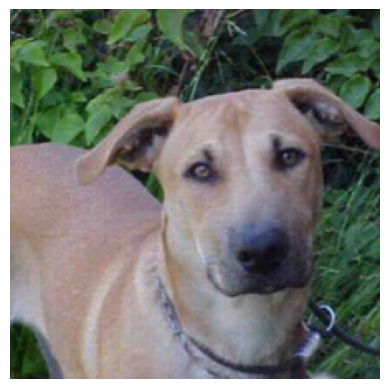

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def imshow(image, ax=None, title=None, normalize=True):
    """Imshow pour tenseur C×H×W."""
    if ax is None:
        fig, ax = plt.subplots()

    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    if title is not None:
        ax.set_title(title)
    return ax

# Tester: afficher une image du premier batch
images, labels = next(iter(dataloader))
imshow(images[0], normalize=False); plt.show()

---
##  2 — Data augmentation (sans normalisation pour la démo)

- **Train** : rotations aléatoires, recadrage aléatoire, flip horizontal, tensor.  
- **Test** : redimensionnement + crop central, tensor.  
- On affiche quelques images transformées pour vérifier visuellement.


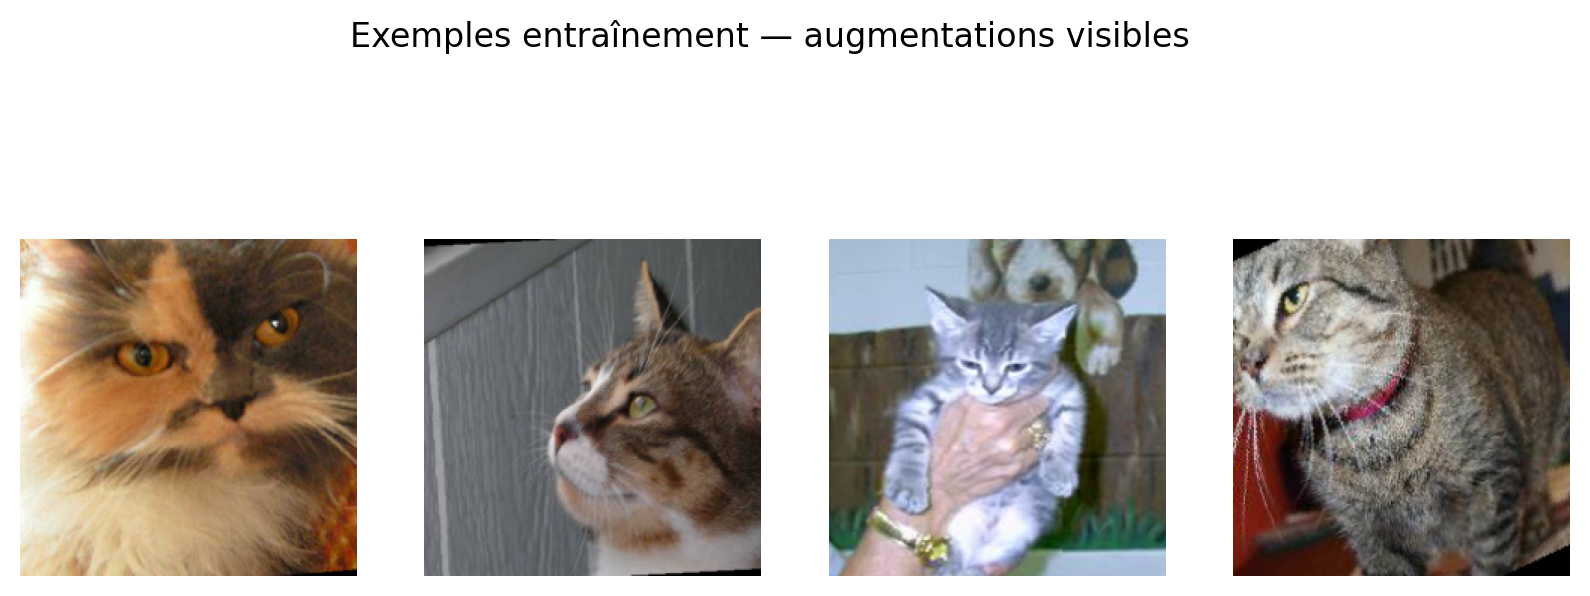

In [ ]:
from torchvision import datasets, transforms
import torch

data_dir = '/content/drive/MyDrive/DIT/Deep learning/devoir/Cat_Dog_data/'

train_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

train_data = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transforms)
test_data  = datasets.ImageFolder(os.path.join(data_dir, 'test'),  transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
testloader  = torch.utils.data.DataLoader(test_data,  batch_size=32, shuffle=False)

# Aperçu visuel
data_iter = iter(trainloader)
images, labels = next(data_iter)

fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    imshow(images[ii], ax=ax, normalize=False)
plt.suptitle('Exemples entraînement — augmentations visibles'); plt.show()

# PROJET — CNN *from scratch* vs **Transfert Learning (ResNet18)**

Nous allons maintenant passer au **pipeline complet** :

1. **Seed & device** (GPU)  
2. **Transforms avec normalisation ImageNet** (utile pour transfert learning)  
3. **Split train/val** (80/20) + DataLoaders  
4. **Boucles d'entraînement & évaluation** (loss, acc, précision, recall, F1)  
5. **Sauvegarde du meilleur modèle** + **rechargement**  
6. **Deux expériences** : SmallCNN (from scratch) & ResNet18 (transfert)  
7. **Courbes** + **Matrice de confusion** sur le test


In [ ]:
# Seed & device
def seed_everything(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Transforms (avec normalisation) & Split Train/Val

- **Normalisation ImageNet** : `mean=[0.485,0.456,0.406]`, `std=[0.229,0.224,0.225]`  
- Split **80/20** pour validation.


In [ ]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

data_dir = '/content/drive/MyDrive/DIT/Deep learning/devoir/Cat_Dog_data/'

train_tf = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

test_tf = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

full_train = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_tf)
test_set   = datasets.ImageFolder(os.path.join(data_dir, 'test'),  transform=test_tf)
class_names = full_train.classes
class_names, len(full_train), len(test_set)

(['cat', 'dog'], 22500, 2500)

In [ ]:
# Split 80/20
val_ratio = 0.2
n = len(full_train)
n_val = int(n * val_ratio)
n_train = n - n_val
train_set, val_set = torch.utils.data.random_split(full_train, [n_train, n_val], generator=torch.Generator().manual_seed(42))

batch_size = 32
num_workers = 2 if torch.cuda.is_available() else 0
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True,  num_workers=num_workers, pin_memory=torch.cuda.is_available())
val_loader   = torch.utils.data.DataLoader(val_set,   batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=torch.cuda.is_available())
test_loader  = torch.utils.data.DataLoader(test_set,  batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=torch.cuda.is_available())

len(train_loader), len(val_loader), len(test_loader)

(563, 141, 79)

## Boucles d'entraînement & Évaluation

- **Critère** : CrossEntropy  
- **Métriques** : accuracy, précision, recall, F1 (macro binaire)  
- **Sauvegarde** du meilleur modèle (selon **val_acc**) dans `checkpoints/`


In [ ]:
def evaluate(model, loader, criterion):
    model.eval()
    losses, preds_all, targets_all, correct, total = [], [], [], 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            losses.append(loss.item())
            _, preds = out.max(1)
            preds_all.extend(preds.detach().cpu().tolist())
            targets_all.extend(y.detach().cpu().tolist())
            correct += (preds == y).sum().item()
            total += y.size(0)
    acc = correct / total if total > 0 else 0.0
    precision = precision_score(targets_all, preds_all, average='binary', zero_division=0)
    recall    = recall_score(targets_all, preds_all, average='binary', zero_division=0)
    f1        = f1_score(targets_all, preds_all, average='binary', zero_division=0)
    return np.mean(losses), acc, precision, recall, f1, np.array(preds_all), np.array(targets_all)

def train_model(model, train_loader, val_loader, optimizer, scheduler=None, epochs=10, run_name='run', save_dir='checkpoints'):
    os.makedirs(save_dir, exist_ok=True)
    criterion = nn.CrossEntropyLoss()
    model = model.to(device)
    best_val_acc = 0.0
    history = {'train_loss':[], 'val_loss':[], 'val_acc':[], 'val_prec':[], 'val_rec':[], 'val_f1':[]}
    ckpt_path = os.path.join(save_dir, f"{run_name}_best.pth")

    for epoch in range(1, epochs+1):
        model.train()
        running_loss, seen = 0.0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad(set_to_none=True)
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * y.size(0)
            seen += y.size(0)
        if scheduler is not None:
            scheduler.step()
        val_loss, val_acc, val_prec, val_rec, val_f1, _, _ = evaluate(model, val_loader, criterion)
        history['train_loss'].append(running_loss/seen if seen>0 else 0.0)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_prec'].append(val_prec)
        history['val_rec'].append(val_rec)
        history['val_f1'].append(val_f1)

        print(f"[{run_name}] Epoch {epoch:02d}/{epochs} | train_loss={running_loss/seen:.4f} | val_loss={val_loss:.4f} acc={val_acc:.4f} prec={val_prec:.4f} rec={val_rec:.4f} f1={val_f1:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({'model_state': model.state_dict(),
                        'best_val_acc': best_val_acc,
                        'epoch': epoch,
                        'run_name': run_name,
                        'class_names': class_names}, ckpt_path)

    # Recharger le meilleur
    if os.path.exists(ckpt_path):
        state = torch.load(ckpt_path, map_location=device)
        model.load_state_dict(state['model_state'])
    return model, history, ckpt_path

*texte en italique*## A — CNN *from scratch* (≥3 blocs conv, BN, Dropout)

- Architecture compacte avec **BatchNorm** (stabilise) et **Dropout** (régularise).  
- **Optimiseur** : Adam (puis optionnellement **SGD** pour comparaison).  
- **Scheduler** : StepLR (réduit LR à intervalles réguliers).


In [ ]:
class SmallCNN(nn.Module):
    def __init__(self, num_classes=2, p_drop=0.3):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.MaxPool2d(2), nn.Dropout(p_drop),

            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(2), nn.Dropout(p_drop),

            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Conv2d(128,128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.MaxPool2d(2), nn.Dropout(p_drop),
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(128, 128), nn.ReLU(inplace=True), nn.Dropout(p_drop),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

model_scratch = SmallCNN(num_classes=2)
opt_scratch = optim.Adam(model_scratch.parameters(), lr=1e-3, weight_decay=1e-4)
sched_scratch = StepLR(opt_scratch, step_size=5, gamma=0.5)

model_scratch, hist_scratch, ckpt_scratch = train_model(
    model_scratch, train_loader, val_loader,
    optimizer=opt_scratch, scheduler=sched_scratch,
    epochs=12, run_name='cnn_scratch'
)

[cnn_scratch] Epoch 01/12 | train_loss=0.6565 | val_loss=0.6361 acc=0.6307 prec=0.6259 rec=0.6531 f1=0.6392
[cnn_scratch] Epoch 02/12 | train_loss=0.6336 | val_loss=0.6440 acc=0.5964 prec=0.5711 rec=0.7808 f1=0.6597
[cnn_scratch] Epoch 03/12 | train_loss=0.6127 | val_loss=0.6387 acc=0.6451 prec=0.7946 rec=0.3931 f1=0.5260
[cnn_scratch] Epoch 04/12 | train_loss=0.5972 | val_loss=0.5734 acc=0.6896 prec=0.6947 rec=0.6783 f1=0.6864
[cnn_scratch] Epoch 05/12 | train_loss=0.5835 | val_loss=0.5965 acc=0.6793 prec=0.7838 rec=0.4969 f1=0.6082
[cnn_scratch] Epoch 06/12 | train_loss=0.5600 | val_loss=0.5692 acc=0.7047 prec=0.8259 rec=0.5200 f1=0.6382
[cnn_scratch] Epoch 07/12 | train_loss=0.5545 | val_loss=0.5830 acc=0.7016 prec=0.8215 rec=0.5164 f1=0.6342
[cnn_scratch] Epoch 08/12 | train_loss=0.5454 | val_loss=0.5262 acc=0.7384 prec=0.7575 rec=0.7028 f1=0.7291
[cnn_scratch] Epoch 09/12 | train_loss=0.5408 | val_loss=0.5475 acc=0.7296 prec=0.8013 rec=0.6118 f1=0.6938
[cnn_scratch] Epoch 10/12 | 

In [ ]:
# Comparaison optimiseur: SGD + CosineAnnealingLR
model_scratch_sgd = SmallCNN(num_classes=2)
opt_sgd = optim.SGD(model_scratch_sgd.parameters(), lr=0.03, momentum=0.9, weight_decay=5e-4)
sched_sgd = CosineAnnealingLR(opt_sgd, T_max=12)
model_scratch_sgd, hist_scratch_sgd, ckpt_scratch_sgd = train_model(
    model_scratch_sgd, train_loader, val_loader,
    optimizer=opt_sgd, scheduler=sched_sgd,
    epochs=12, run_name='cnn_scratch_sgd'
)

[cnn_scratch_sgd] Epoch 01/12 | train_loss=0.6689 | val_loss=0.6404 acc=0.6260 prec=0.6551 rec=0.5350 f1=0.5890
[cnn_scratch_sgd] Epoch 02/12 | train_loss=0.6451 | val_loss=0.6510 acc=0.6116 prec=0.5938 rec=0.7103 f1=0.6469
[cnn_scratch_sgd] Epoch 03/12 | train_loss=0.6241 | val_loss=0.6037 acc=0.6722 prec=0.6632 rec=0.7023 f1=0.6822
[cnn_scratch_sgd] Epoch 04/12 | train_loss=0.6073 | val_loss=0.6338 acc=0.6436 prec=0.6073 rec=0.8159 f1=0.6963
[cnn_scratch_sgd] Epoch 05/12 | train_loss=0.5964 | val_loss=0.5908 acc=0.6787 prec=0.6967 rec=0.6349 f1=0.6643
[cnn_scratch_sgd] Epoch 06/12 | train_loss=0.5798 | val_loss=0.6110 acc=0.6640 prec=0.8595 rec=0.3935 f1=0.5399
[cnn_scratch_sgd] Epoch 07/12 | train_loss=0.5669 | val_loss=0.5958 acc=0.6722 prec=0.8603 rec=0.4126 f1=0.5577
[cnn_scratch_sgd] Epoch 08/12 | train_loss=0.5498 | val_loss=0.6299 acc=0.6556 prec=0.8705 rec=0.3669 f1=0.5162
[cnn_scratch_sgd] Epoch 09/12 | train_loss=0.5380 | val_loss=0.5305 acc=0.7304 prec=0.6993 rec=0.8101 f1


## B — Transfert Learning (ResNet18)

- Chargement des **poids ImageNet** puis adaptation de la **tête** (Dropout + Linear).  
- **Phase 1** : geler le backbone, n'entraîner que la tête.  
- **Phase 2** : **fine-tuning** complet (dé-geler) avec **SGD** + CosineAnnealingLR.


In [ ]:
# ResNet18 (poids ImageNet)
try:
    from torchvision.models import resnet18, ResNet18_Weights
    weights = ResNet18_Weights.IMAGENET1K_V1
    base = resnet18(weights=weights)
except Exception as e:
    print('Fallback torchvision.models.resnet18(pretrained=True):', e)
    base = models.resnet18(pretrained=True)

in_features = base.fc.in_features
base.fc = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(in_features, 2)
)

# Phase 1: geler le backbone
for p in base.parameters():
    p.requires_grad = False
for p in base.fc.parameters():
    p.requires_grad = True

opt_resnet = optim.Adam(filter(lambda p: p.requires_grad, base.parameters()), lr=1e-3)
sched_resnet = StepLR(opt_resnet, step_size=4, gamma=0.5)

base, hist_resnet_phase1, ckpt_resnet = train_model(
    base, train_loader, val_loader, optimizer=opt_resnet, scheduler=sched_resnet,
    epochs=6, run_name='resnet18_head'
)

# Phase 2: dé-geler tout et fine-tuner
for p in base.parameters():
    p.requires_grad = True

opt_resnet_ft = optim.SGD(base.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)
sched_resnet_ft = CosineAnnealingLR(opt_resnet_ft, T_max=8)

base, hist_resnet_phase2, ckpt_resnet_ft = train_model(
    base, train_loader, val_loader, optimizer=opt_resnet_ft, scheduler=sched_resnet_ft,
    epochs=8, run_name='resnet18_finetune'
)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 124MB/s]


[resnet18_head] Epoch 01/6 | train_loss=0.2740 | val_loss=0.1843 acc=0.9231 prec=0.9813 rec=0.8629 f1=0.9183
[resnet18_head] Epoch 02/6 | train_loss=0.2390 | val_loss=0.1494 acc=0.9349 prec=0.9360 rec=0.9339 f1=0.9349
[resnet18_head] Epoch 03/6 | train_loss=0.2265 | val_loss=0.1555 acc=0.9344 prec=0.9618 rec=0.9051 f1=0.9326
[resnet18_head] Epoch 04/6 | train_loss=0.2326 | val_loss=0.1541 acc=0.9307 prec=0.9646 rec=0.8944 f1=0.9282
[resnet18_head] Epoch 05/6 | train_loss=0.2292 | val_loss=0.1537 acc=0.9360 prec=0.9230 rec=0.9516 f1=0.9371
[resnet18_head] Epoch 06/6 | train_loss=0.2205 | val_loss=0.1637 acc=0.9342 prec=0.9794 rec=0.8873 f1=0.9311
[resnet18_finetune] Epoch 01/8 | train_loss=0.1800 | val_loss=0.1025 acc=0.9553 prec=0.9626 rec=0.9476 f1=0.9551
[resnet18_finetune] Epoch 02/8 | train_loss=0.1384 | val_loss=0.0947 acc=0.9589 prec=0.9726 rec=0.9445 f1=0.9584
[resnet18_finetune] Epoch 03/8 | train_loss=0.1254 | val_loss=0.0885 acc=0.9642 prec=0.9628 rec=0.9658 f1=0.9643
[resnet

## Courbes d’apprentissage (loss & métriques)

Visualisons l’évolution de la **loss**, **accuracy**, **précision**, **recall**, **F1** sur la validation.


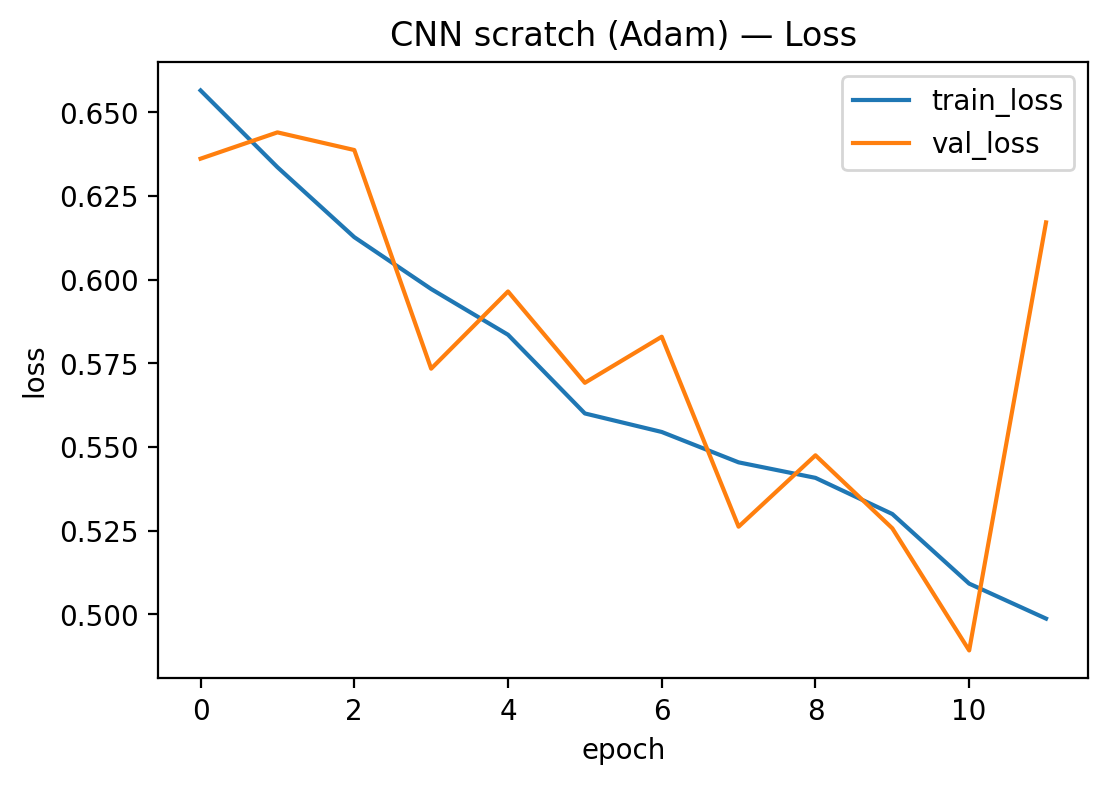

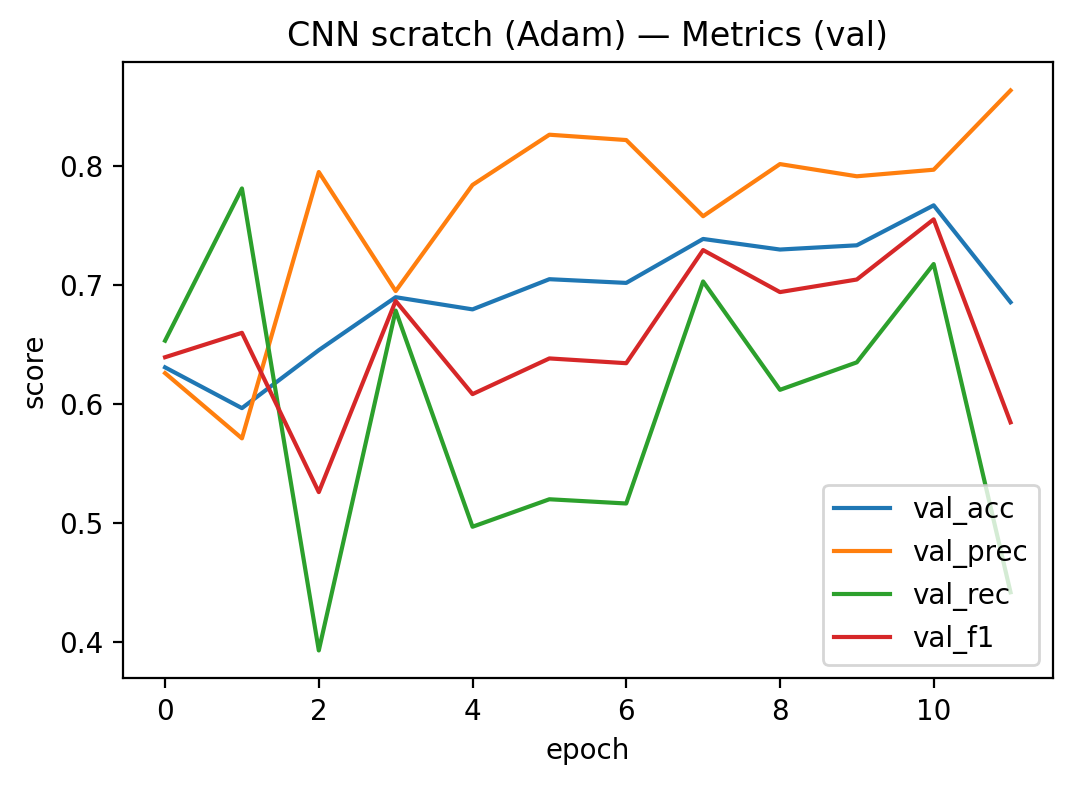

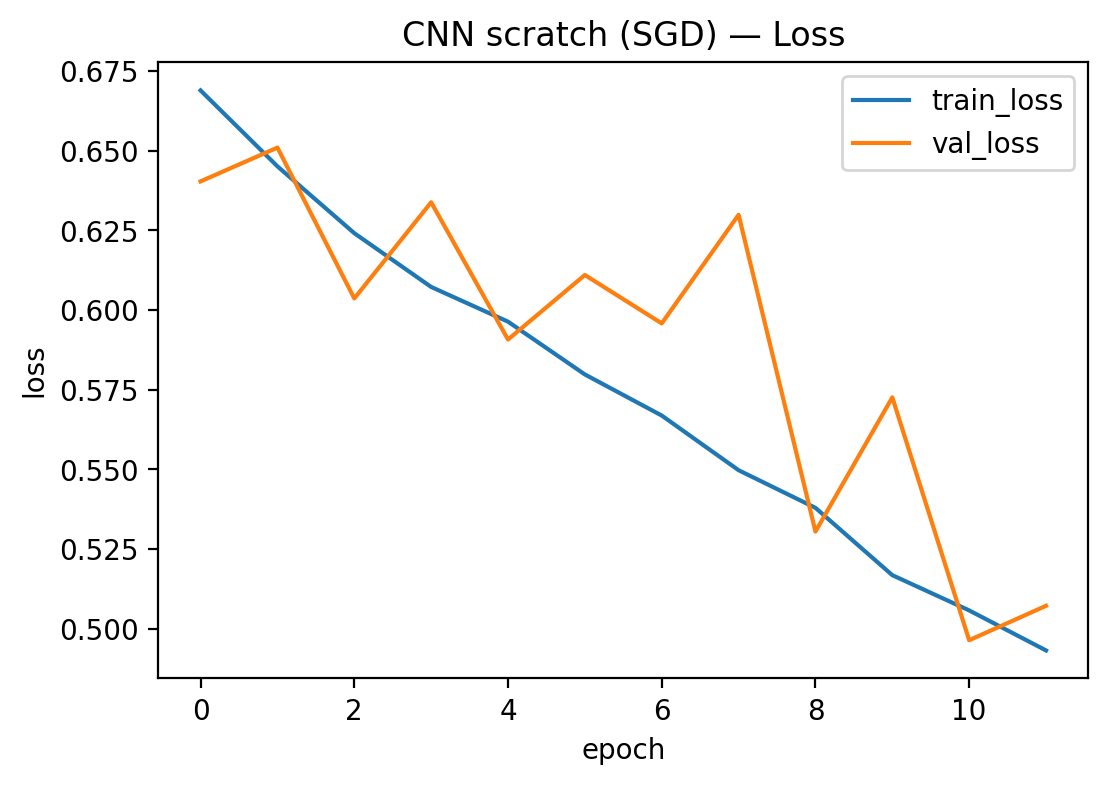

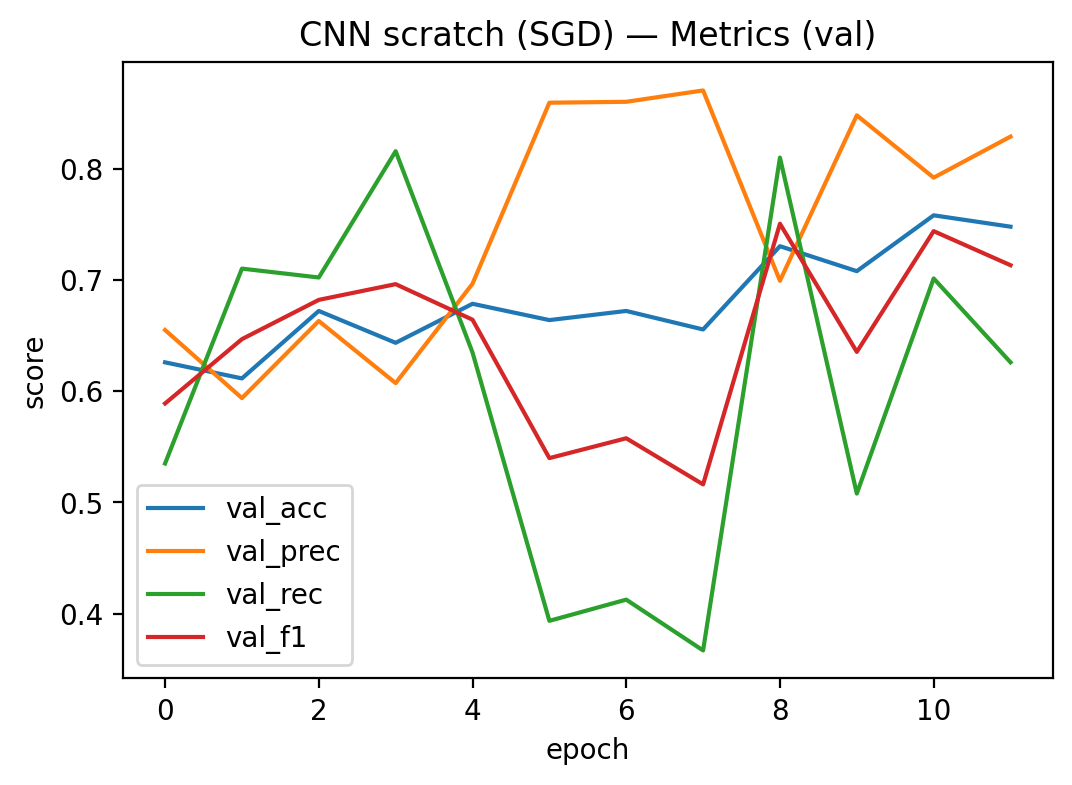

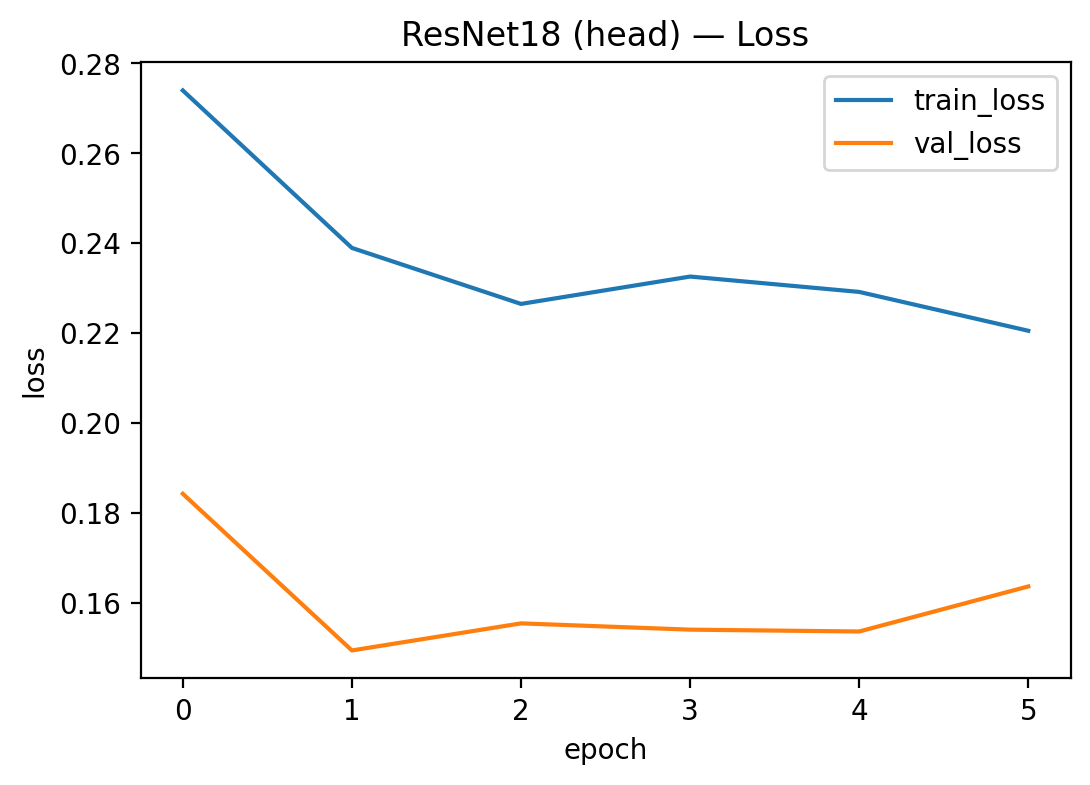

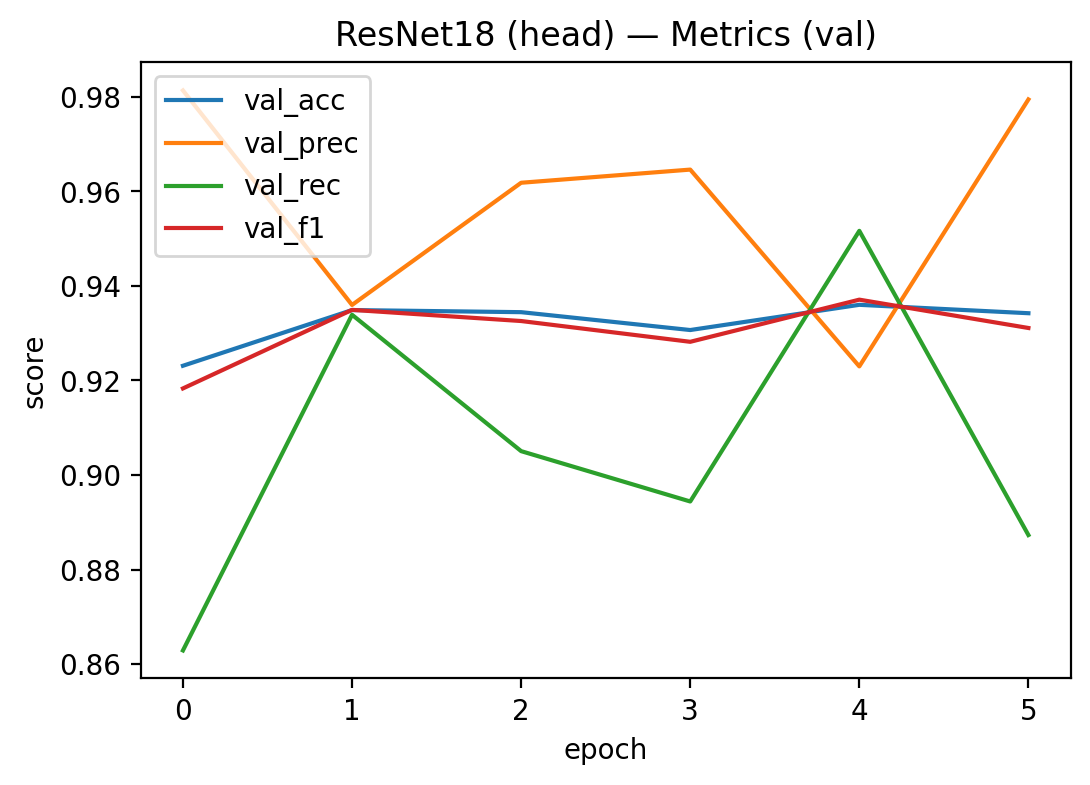

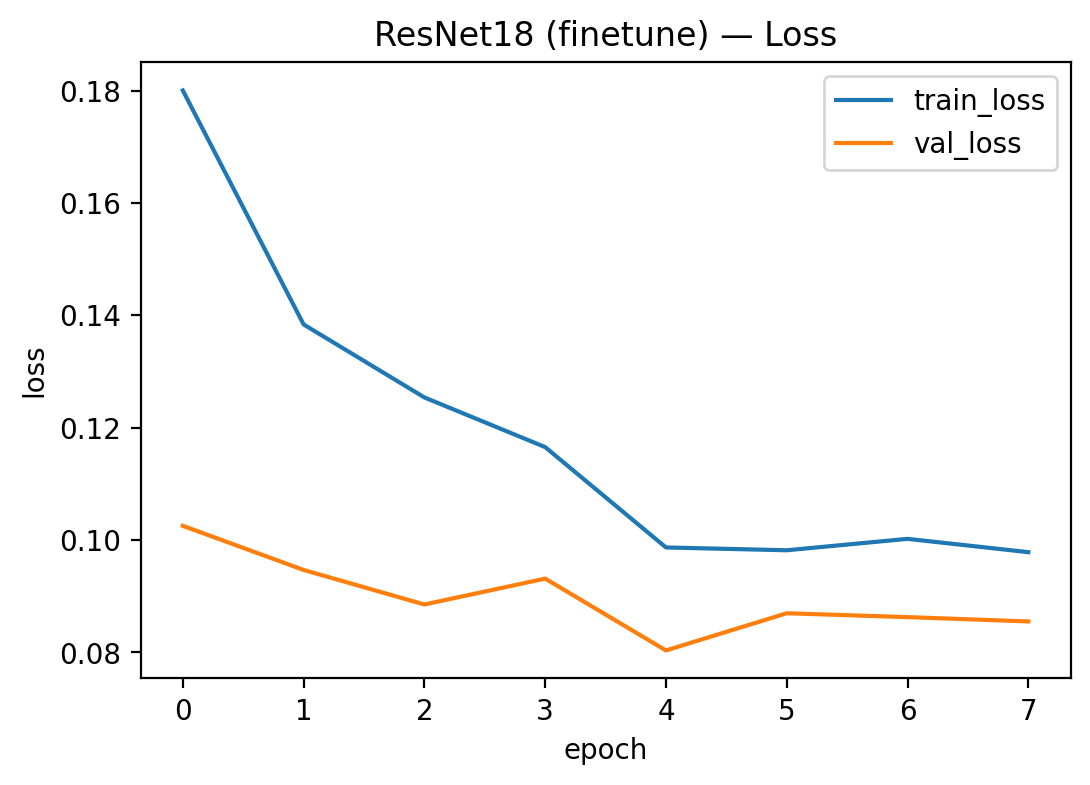

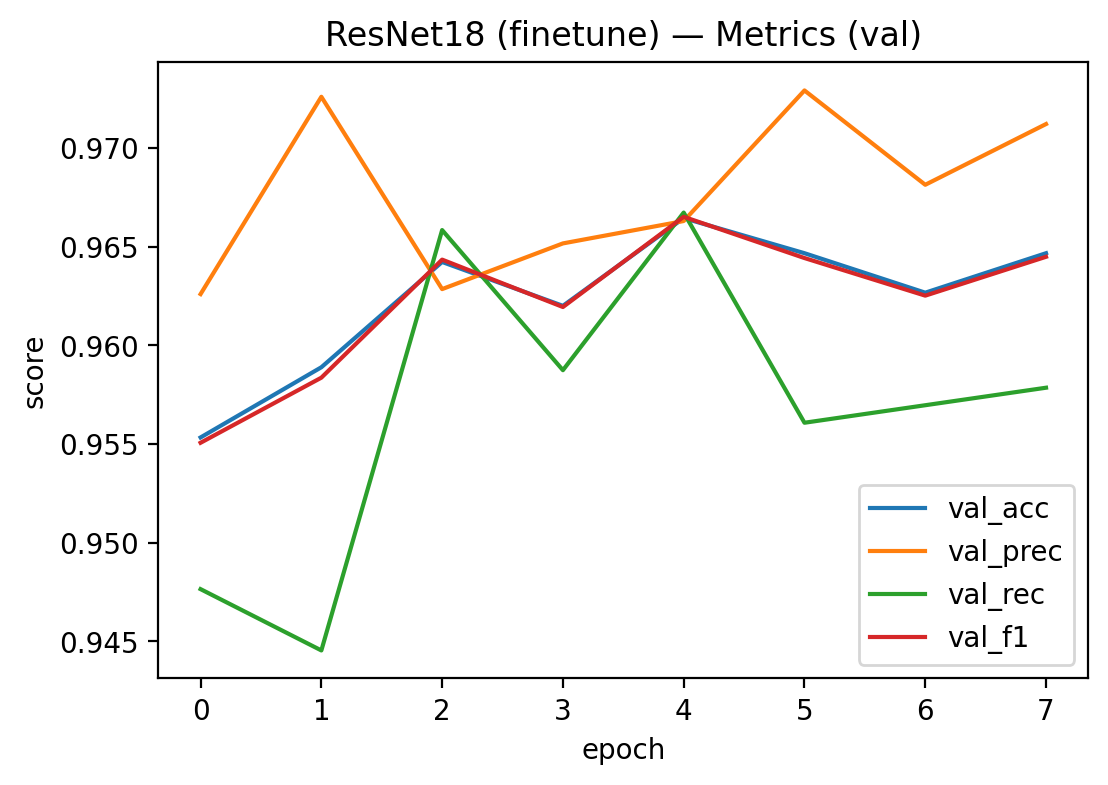

In [ ]:
def plot_history(hist, title):
    plt.figure(figsize=(6,4))
    plt.plot(hist.get('train_loss', []), label='train_loss')
    plt.plot(hist.get('val_loss', []), label='val_loss')
    plt.legend(); plt.title(title + ' — Loss'); plt.xlabel('epoch'); plt.ylabel('loss'); plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(hist.get('val_acc', []), label='val_acc')
    plt.plot(hist.get('val_prec', []), label='val_prec')
    plt.plot(hist.get('val_rec', []), label='val_rec')
    plt.plot(hist.get('val_f1', []), label='val_f1')
    plt.legend(); plt.title(title + ' — Metrics (val)'); plt.xlabel('epoch'); plt.ylabel('score'); plt.show()

plot_history(hist_scratch, 'CNN scratch (Adam)')
try:
    plot_history(hist_scratch_sgd, 'CNN scratch (SGD)')
except Exception as e:
    print('Courbes SGD ignorées:', e)
plot_history(hist_resnet_phase1, 'ResNet18 (head)')
plot_history(hist_resnet_phase2, 'ResNet18 (finetune)')

## Évaluation finale (test) + Matrice de confusion

On évalue le **meilleur modèle**  sur le **jeu de test**.


TEST — loss=0.0259 acc=0.9884 precision=0.9896 recall=0.9872 f1=0.9884


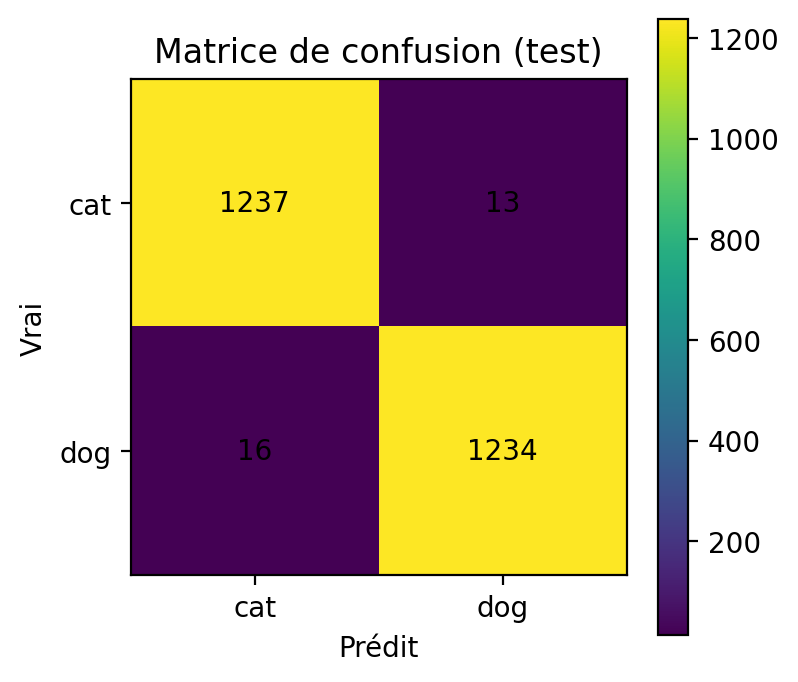

In [ ]:
criterion = nn.CrossEntropyLoss()

# Choix: meilleur ckpt du transfert
best_model = base  # déjà au meilleur état rechargé par train_model

test_loss, test_acc, test_prec, test_rec, test_f1, yhat, ytrue = evaluate(best_model, test_loader, criterion)
print(f"TEST — loss={test_loss:.4f} acc={test_acc:.4f} precision={test_prec:.4f} recall={test_rec:.4f} f1={test_f1:.4f}")

cm = confusion_matrix(ytrue, yhat)
plt.figure(figsize=(4,4))
plt.imshow(cm, interpolation='nearest')
plt.title('Matrice de confusion (test)')
plt.xticks([0,1], class_names); plt.yticks([0,1], class_names)
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i,j], ha='center', va='center')
plt.ylabel('Vrai'); plt.xlabel('Prédit')
plt.colorbar(); plt.show()

## Recharger un modèle sauvegardé

recharger le **SmallCNN** meilleur et ré-évaluer sur le test.


In [ ]:
def make_scratch():
    return SmallCNN(num_classes=2)

def load_best(ckpt_path, model_fn):
    model = model_fn().to(device)
    state = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(state['model_state'])
    return model

try:
    reloaded = load_best(ckpt_scratch, make_scratch)
    t_loss, t_acc, t_prec, t_rec, t_f1, _, _ = evaluate(reloaded, test_loader, nn.CrossEntropyLoss())
    print(f"[Reloaded scratch] TEST — acc={t_acc:.4f}, prec={t_prec:.4f}, rec={t_rec:.4f}, f1={t_f1:.4f}")
except Exception as e:
    print('Recharge scratch impossible (vérifiez ckpt_scratch):', e)

[Reloaded scratch] TEST — acc=0.7992, prec=0.8061, rec=0.7880, f1=0.7969
